<a href="https://colab.research.google.com/github/LiLAlien28/Arch_Tech_internship/blob/main/Task1_Email_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# For machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Download NLTK stopwords
nltk.download('stopwords')

print("All libraries imported successfully!")

All libraries imported successfully!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Load the dataset from URL
url = "https://raw.githubusercontent.com/justmarkham/pydata-dc-2016-tutorial/master/sms.tsv"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset shape: (5572, 2)

First 5 rows:


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Missing values:
label      0
message    0
dtype: int64

Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


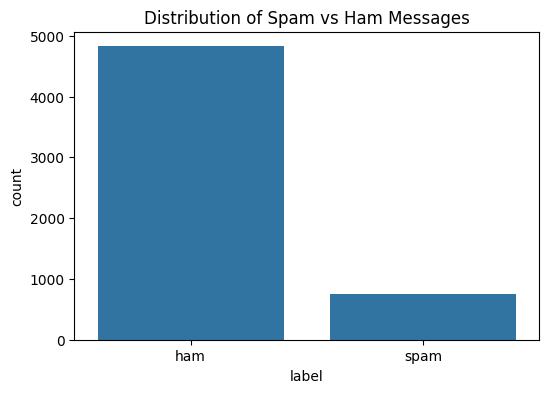

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [3]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Check the distribution of labels
print("\nLabel distribution:")
print(df['label'].value_counts())

# Visualize the distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label')
plt.title('Distribution of Spam vs Ham Messages')
plt.show()

# Convert labels to binary (ham=0, spam=1) for modeling
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

# Check the first few rows again to confirm
df.head()

In [4]:
# Initialize stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Function to clean and preprocess text data
    """
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation and special characters (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize (split into words)
    words = text.split()

    # Remove stopwords and apply stemming
    words = [stemmer.stem(word) for word in words if word not in stop_words]

    # Join words back into a single string
    cleaned_text = ' '.join(words)

    return cleaned_text

# Test the function on a sample message
sample_message = df['message'][0]
print("Original message:", sample_message)
print("\nCleaned message:", preprocess_text(sample_message))

Original message: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Cleaned message: go jurong point crazi avail bugi n great world la e buffet cine got amor wat


In [5]:
# Apply preprocessing to all messages (this might take a few seconds)
print("Preprocessing messages...")
df['cleaned_message'] = df['message'].apply(preprocess_text)

# Display the results
print("\nComparison of original vs cleaned messages:")
comparison_df = df[['message', 'cleaned_message', 'label']].head(10)
comparison_df

Preprocessing messages...

Comparison of original vs cleaned messages:


,message,cleaned_message,label
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...,ham
1,Ok lar... Joking wif u oni...,ok lar joke wif u oni,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...,spam
3,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say,ham
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though,ham
5,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darl week word back id like fun st...,spam
6,Even my brother is not like to speak with me. ...,even brother like speak treat like aid patent,ham
7,As per your request 'Melle Melle (Oru Minnamin...,per request mell mell oru minnaminungint nurun...,ham
8,WINNER!! As a valued network customer you have...,winner valu network custom select receivea pri...,spam
9,Had your mobile 11 months or more? U R entitle...,mobil month u r entitl updat latest colour mob...,spam


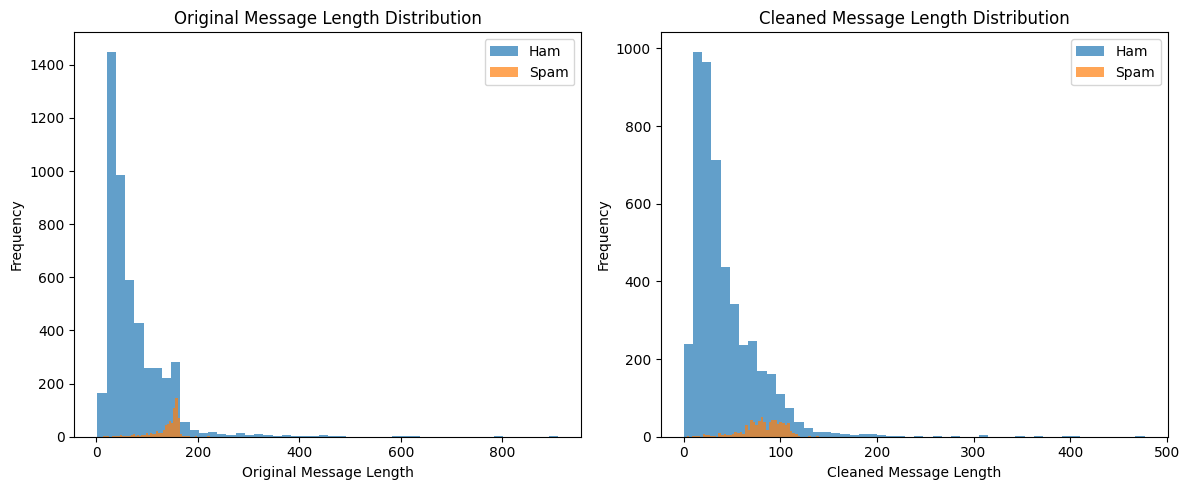

Number of messages that became empty after preprocessing: 6
Sample of empty messages:
                       message label
960                    Where @   ham
1612                       645   ham
2807                Can a not?   ham
3376                       :)    ham
4575  :( but your not here....   ham


In [6]:
# Compare message lengths before and after preprocessing
df['original_length'] = df['message'].apply(len)
df['cleaned_length'] = df['cleaned_message'].apply(len)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df[df['label']=='ham']['original_length'], alpha=0.7, label='Ham', bins=50)
plt.hist(df[df['label']=='spam']['original_length'], alpha=0.7, label='Spam', bins=50)
plt.xlabel('Original Message Length')
plt.ylabel('Frequency')
plt.title('Original Message Length Distribution')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(df[df['label']=='ham']['cleaned_length'], alpha=0.7, label='Ham', bins=50)
plt.hist(df[df['label']=='spam']['cleaned_length'], alpha=0.7, label='Spam', bins=50)
plt.xlabel('Cleaned Message Length')
plt.ylabel('Frequency')
plt.title('Cleaned Message Length Distribution')
plt.legend()

plt.tight_layout()
plt.show()

# Check if any messages become empty after preprocessing
empty_messages = df[df['cleaned_message'] == '']
print(f"Number of messages that became empty after preprocessing: {len(empty_messages)}")
if len(empty_messages) > 0:
    print("Sample of empty messages:")
    print(empty_messages[['message', 'label']].head())

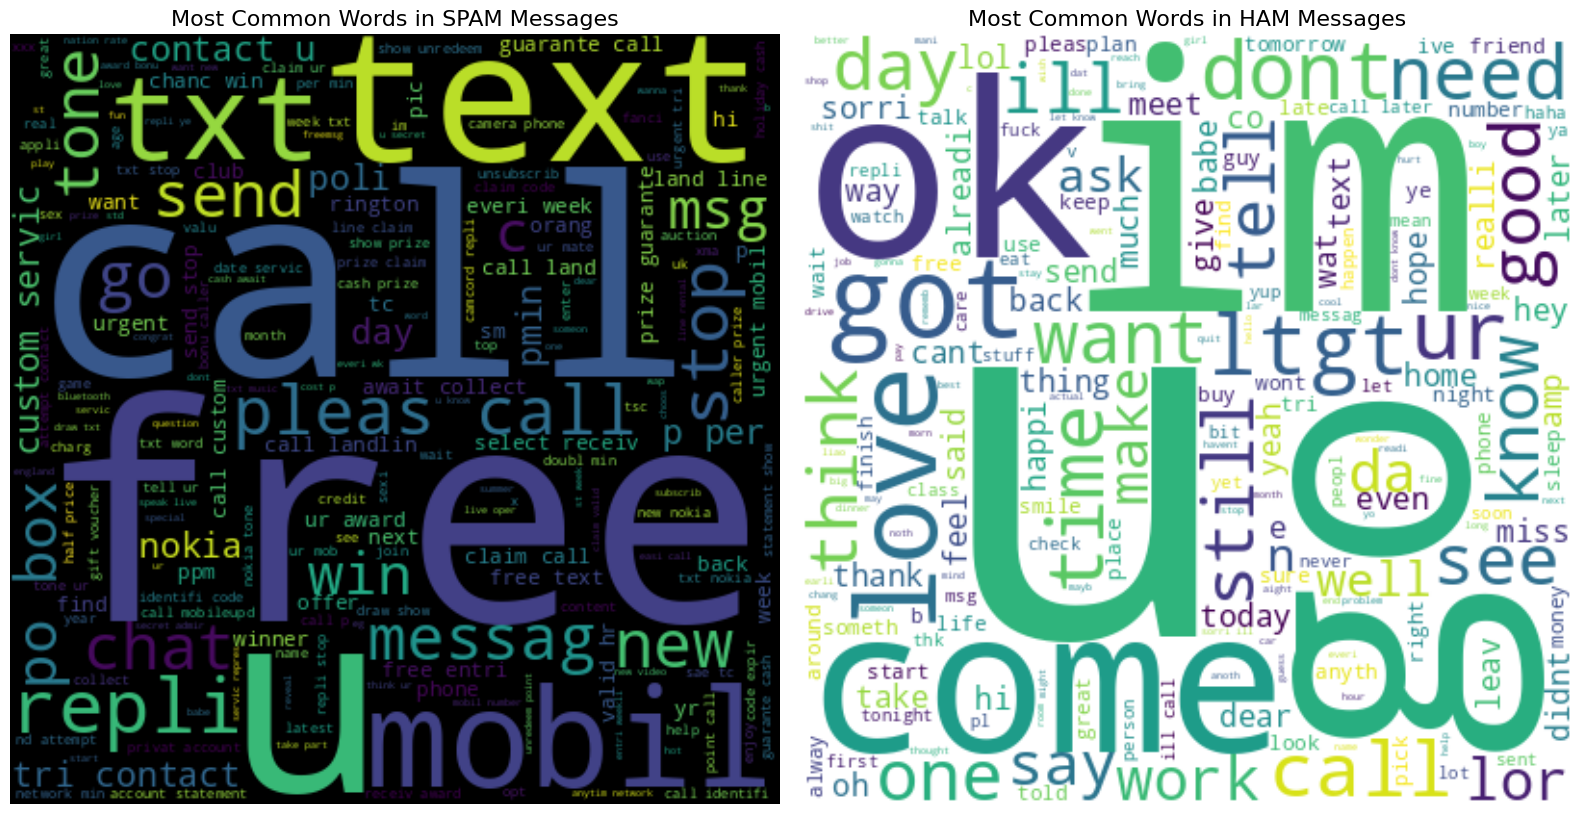

In [7]:
# Install wordcloud if not already available
!pip install wordcloud

from wordcloud import WordCloud

# Separate spam and ham messages
spam_messages = ' '.join(df[df['label']=='spam']['cleaned_message'])
ham_messages = ' '.join(df[df['label']=='ham']['cleaned_message'])

# Create word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
wordcloud_spam = WordCloud(width=400, height=400, background_color='black').generate(spam_messages)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.title('Most Common Words in SPAM Messages', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_ham = WordCloud(width=400, height=400, background_color='white').generate(ham_messages)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.title('Most Common Words in HAM Messages', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Prepare features and target
X = df['cleaned_message']  # Cleaned text messages
y = df['label_num']        # Binary labels (0=ham, 1=spam)

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,  # for reproducibility
    stratify=y        # maintain same class distribution in train and test
)

print(f"Training set size: {len(X_train)} messages")
print(f"Testing set size: {len(X_test)} messages")
print(f"\nTraining set distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTesting set distribution:")
print(y_test.value_counts(normalize=True))

Training set size: 4457 messages
Testing set size: 1115 messages

Training set distribution:
label_num
0    0.865829
1    0.134171
Name: proportion, dtype: float64

Testing set distribution:
label_num
0    0.866368
1    0.133632
Name: proportion, dtype: float64
